# Preprocess
Preparing proper and ready-to-use train-validate-test datasets for modelling.
<br>You can see summary of the process in the cell output along with time taken.

In [117]:
import time
preprocess_start_time = time.time()
import os
import pandas as pd
INPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'input', 'celeba-subset')
TXT = 'list_attribute.txt'
INPUT_IMAGES_DIR = os.path.join(INPUT_DIR, 'Images')
INPUT_IMAGES_LIST = os.listdir(INPUT_IMAGES_DIR)


print("\nCopying image files to ./images, please wait...")
start_time = time.time()
import shutil
IMAGES_DIR = os.path.join(os.getcwd(), 'images')
try:
    shutil.rmtree(IMAGES_DIR)
    os.rmdir(IMAGES_DIR)
    print(f"'{IMAGES_DIR}' is found. Deleted successfully.")
    os.makedirs(IMAGES_DIR, exist_ok=True)
    print(f"'{IMAGES_DIR}' is created")
except FileNotFoundError:
    pass
shutil.copytree(INPUT_IMAGES_DIR, IMAGES_DIR, dirs_exist_ok=True)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nFinding and removing duplicates, please wait...")
start_time = time.time()
from PIL import Image
import imagehash
def remove_duplicate_images(directory):
    image_hash_map = {}
    removed_files = [] 
    for filename in os.listdir(directory):
        if not filename.endswith(('.png', '.jpg', '.jpeg')):
            continue
        if "(1)" in filename:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename)  
            continue
        with open(os.path.join(directory, filename), 'rb') as f:
            img = Image.open(f)
            img_hash = imagehash.average_hash(img)
        if img_hash in image_hash_map:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename) 
        else:
            image_hash_map[img_hash] = filename          
    return removed_files 

removed_files = remove_duplicate_images(IMAGES_DIR)
for filename in removed_files:
    print("Removed:", filename)
print(f"Number of files in {IMAGES_DIR}: {len(os.listdir(IMAGES_DIR))}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print(f"\nConverting {TXT} to a dataframe then filter it down to the filename and male feature.")
start_time = time.time()
df_preprocess = pd.read_csv(os.path.join(INPUT_DIR, TXT), sep="\s+", index_col=0, skiprows=1)
df_preprocess = df_preprocess[['Male']]
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nReordering dataframe columns..")
start_time = time.time()
df_preprocess.reset_index(inplace=True)          
df_preprocess = df_preprocess[['index', 'Male']] 
df_preprocess.columns = ['Filename', 'Male']     
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nSyncing dataframe with files in .input/celeba-subset/Images")
start_time = time.time()
df_preprocess = df_preprocess[df_preprocess['Filename'].isin(os.listdir(IMAGES_DIR))] 
if len(df_preprocess) == len(os.listdir(IMAGES_DIR)):
    match_str = " (MATCH)"
else:
    match_str = ""
print(f"Number of rows in dataframe: {len(df_preprocess)}{match_str}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nEncoding the -1 in Male to 0 to facilitate the use of Binary Crossentropy Loss later.")
start_time = time.time()
df_preprocess.loc[ df_preprocess['Male'] == -1, ['Male'] ] = 0
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nReset dataframe index & reorder columns")
start_time = time.time()
df_preprocess.reset_index(inplace=True)
df_preprocess = df_preprocess[['Filename', 'Male']]
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nTrain : Validate : Test = 70 : 20 : 10")
print("Moving files from ./images to ./train/male ./train/female ./val/male ./val/female ./test/male ./test/female")
print("Please wait..")
from functools import partial
from typing import Tuple
from sklearn.model_selection import train_test_split 

def create_directory(directory: str) -> None:
    os.makedirs(directory, exist_ok=True)

def create_train_test_val_dirs() -> Tuple[str, str, str, str, str, str]:
    train_dir_female = os.path.join(os.getcwd(), 'train', 'female')
    train_dir_male = os.path.join(os.getcwd(), 'train', 'male')
    test_dir_female = os.path.join(os.getcwd(), 'test', 'female')
    test_dir_male = os.path.join(os.getcwd(), 'test', 'male')
    val_dir_female = os.path.join(os.getcwd(), 'val', 'female')
    val_dir_male = os.path.join(os.getcwd(), 'val', 'male')
    for directory in [train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male]:
        create_directory(directory)
    return train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male

df_train, df_validate_test = train_test_split(df_preprocess, test_size=0.3, random_state=42, stratify=df_preprocess['Male'])
df_val, df_test = train_test_split(df_validate_test, test_size=1/3, random_state=42, stratify=df_validate_test['Male'])
train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male = create_train_test_val_dirs()
combined_df = pd.concat([df_train, df_val, df_test])

for index, row in combined_df.iterrows():
    filename, male_value = row[['Filename', 'Male']]
    source_file = os.path.join(IMAGES_DIR, filename)
    if male_value == 1:
        dest_dir = train_dir_male if index in df_train.index else (val_dir_male if index in df_val.index else test_dir_male)
    else:
        dest_dir = train_dir_female if index in df_train.index else (val_dir_female if index in df_val.index else test_dir_female)
    shutil.move(source_file, os.path.join(dest_dir, filename))

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nRemoving images directory after processing, please wait...")
shutil.rmtree(IMAGES_DIR)
# os.rmdir(IMAGES_DIR)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nYour dataset is ready, here\'s the breakdown:")
train_male_count = len(os.listdir(train_dir_male))
train_female_count = len(os.listdir(train_dir_female))
val_male_count = len(os.listdir(val_dir_male))
val_female_count = len(os.listdir(val_dir_female))
test_male_count = len(os.listdir(test_dir_male))
test_female_count = len(os.listdir(test_dir_female))
train_val_test_count = train_male_count+train_female_count+val_male_count+val_female_count+test_male_count+test_female_count

print(f"{train_dir_male}   : {train_male_count} images ({round(train_male_count/train_val_test_count*100)}%)")
print(f"{train_dir_female} : {train_female_count} images ({round(train_female_count/train_val_test_count*100)}%)")
print(f"{val_dir_male}     : {val_male_count}  images ({round(val_male_count/train_val_test_count*100)}%)")
print(f"{val_dir_female}   : {val_female_count}  images ({round(val_female_count/train_val_test_count*100)}%)")
print(f"{test_dir_male}    : {test_male_count}  images ({round(test_male_count/train_val_test_count*100)}%)")
print(f"{test_dir_female}  : {test_female_count}  images ({round(test_female_count/train_val_test_count*100)}%)")


preprocess_inference_time = time.time() - preprocess_start_time
print("\nPreprocess finished in total of {:.6f} seconds".format(preprocess_inference_time))


Copying image files to ./images, please wait...


KeyboardInterrupt: 

# ResNet152 Transfer Learning

## Define the train, validate and test dataframes
These dataframes will be used by the ``ImageDataGenerator``

In [ ]:
def create_DF(path):
    label = []
    data = []
    for fold in os.listdir(path):
        fold_path = os.path.join(path, fold)
        for file in os.listdir(fold_path):
            file_path = os.path.join(fold_path, file)
            label.append(fold)
            data.append(file_path)
    LS = pd.Series(label, name='label')
    DS = pd.Series(data, name='filepath')
    DF = pd.concat([DS, LS], axis=1)
    return DF

start_time = time.time()

train_path=os.path.join(os.getcwd(), 'train')
test_path=os.path.join(os.getcwd(), 'test')
val_path=os.path.join(os.getcwd(), 'val')

train_df=create_DF(train_path)
test_df=create_DF(test_path)
val_df=create_DF(val_path)

print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"val_df shape: {val_df.shape}")

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Define generators for training, validating and testing
Image transformation happen here, along with training and testing batch sizes

In [ ]:
start_time = time.time()

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
img_size = (224, 224)
channels = 3 
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(
    preprocessing_function= scalar,
    horizontal_flip= True 
#     ,rescale=1./255  # Normalize pixel values to [0,1]
    ,rotation_range=20
    ,fill_mode='nearest'
    ,width_shift_range=0.1
    ,height_shift_range=0.1
    ,shear_range=0.2
    ,zoom_range=0.2
)
ts_gen = ImageDataGenerator(
    preprocessing_function= scalar
#     rescale=1./255
)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

val_gen = ts_gen.flow_from_dataframe( val_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size, seed=42)

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Visualize training dataset

In [ ]:
start_time = time.time()

import matplotlib.pyplot as plt

batch = next(train_gen)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        axs[i, j].imshow(batch[0][index])
        axs[i, j].axis('off')
        gender_label = "male" if batch[1][index] == 1.0 else "female"
        axs[i, j].set_title(f'Gender: {gender_label}')

plt.tight_layout()
plt.show()

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Define & Download ResNet152 Model
Keep all functional layers frozen

In [ ]:
start_time = time.time()

from tensorflow.keras.applications import ResNet152

TL_Models = [
    ResNet152(input_shape=(img_size[0], img_size[1], 3), weights='imagenet', include_top=False)
]

for tl_model in TL_Models:
    tl_model.trainable = False

for tl_model in TL_Models:
    for layer in tl_model.layers:
        if layer.name.startswith('conv5_block3'):
            layer.trainable = True

Models_NAMES = ['ResNet152']

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Define Callback Functions

In [ ]:
from keras.callbacks import Callback

### Callback: Dropout Scheduler

In [ ]:
class DropoutScheduler(Callback):
    def __init__(self, dropout_schedule):
        super(DropoutScheduler, self).__init__()
        self.dropout_schedule = dropout_schedule

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.dropout_schedule:
            new_dropout_rate = self.dropout_schedule[epoch]
            for layer in self.model.layers:
                if isinstance(layer, layers.Dropout):
                    layer.rate = new_dropout_rate
            print(f"\nDropout rate set to {new_dropout_rate} for epoch {epoch+1}")

dropout_schedule = {0:0.05, 10:0.1, 20:0.15, 30:0.2, 40:0.2, 50:0.3, 60:0.35, 70:0.4, 80:0.45, 90:0.5}
dropout_scheduler = DropoutScheduler(dropout_schedule)

### Callback: Reduce Learning Rate on Plateau

In [ ]:
from keras.callbacks import ReduceLROnPlateau
RLR_MON = 'val_loss'
RLR_PAT = 5
RLR_F = 0.5
RLR_MLR = 0.00001
RLR_VRB = 1

### Callback: Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping
ES_MON = 'val_loss'
ES_PAT = 15
ES_VRB = 1

### Callback: L2 Regularization

In [ ]:
class L2RegularizationCallback(Callback):
    def __init__(self, l2_penalty):
        super(L2RegularizationCallback, self).__init__()
        self.l2_penalty = l2_penalty

    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if isinstance(layer, layers.Dense):
                layer.kernel_regularizer = regularizers.l2(self.l2_penalty)

## Train and optimize the model

In [118]:
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.callbacks import LearningRateScheduler
from keras import optimizers

EPOCH_COUNT= 100
optimizer = 'adam' #SGD(learning_rate=1e-3, momentum=0.9) #Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
# INIT_LR = 1e-3
# LR_Scheduler = LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(EPOCH_COUNT/20))
# optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCH_COUNT)

HEAD_DROPOUT_RATE=0.1
HEAD_DENSE_NEURONS=img_size[0]

training_times = []
model_histories = []

for i, tl_model in enumerate(tqdm(TL_Models, desc="Training TL Models")):
    print(f"Training Model {i}: {tl_model.name}")

    model = keras.Sequential([
        tl_model,
#         layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(HEAD_DENSE_NEURONS, activation='relu'),
        layers.Dropout(HEAD_DROPOUT_RATE),
        layers.Dense(1, activation='sigmoid')
    ])

    start_time = time.time()

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    cbs = [
        ReduceLROnPlateau(monitor=RLR_MON, patience=RLR_PAT, factor=RLR_F, min_lr=RLR_MLR, verbose=1),
#         LR_Scheduler,
        EarlyStopping(monitor=ES_MON, patience=ES_PAT, restore_best_weights=True, verbose=1),
        ModelCheckpoint(tl_model.name + ".keras", save_best_only=True)
    ]
    
    history = model.fit(train_gen, epochs=EPOCH_COUNT, validation_data=val_gen, callbacks=[cbs])
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    model_histories.append(history.history)

for i, time_taken in enumerate(training_times):
    print(f"Model {i+1}: {tl_model.name} Training time: {time_taken:.2f} seconds")

Training TL Models:   0%|          | 0/1 [00:00<?, ?it/s]

Training Model 0: resnet152
Epoch 1/100


W0000 00:00:1710732219.877872     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/55 ━━━━━━━━━━━━━━━━━━━━ 28s 611ms/step - accuracy: 0.6865 - loss: 0.7331

W0000 00:00:1710732236.294001     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8451 - loss: 0.3757

W0000 00:00:1710732276.276983     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710732286.559791     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8460 - loss: 0.3736 - val_accuracy: 0.9127 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 779ms/step - accuracy: 0.9335 - loss: 0.1704 - val_accuracy: 0.9106 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 731ms/step - accuracy: 0.9407 - loss: 0.1520 - val_accuracy: 0.8916 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 770ms/step - accuracy: 0.9641 - loss: 0.1075 - val_accuracy: 0.9327 - val_loss: 0.1861 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 731ms/step - accuracy: 0.9619 - loss: 0.0992 - val_accuracy: 0.8544 - val_loss: 0.5654 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 734ms/step - accuracy: 0.9605 - loss: 0.1127 - val_accuracy: 0.9177 - val_loss: 0.3145 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 740ms/step - accuracy: 0.9650 - loss: 0.0916 - 

Training TL Models: 100%|██████████| 1/1 [16:02<00:00, 962.94s/it]

Model 1: resnet152 Training time: 962.93 seconds


### Validation Accuracy & loss

/tmp/ipykernel_34/3978217286.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, i+1)  # Create subplots for each metric


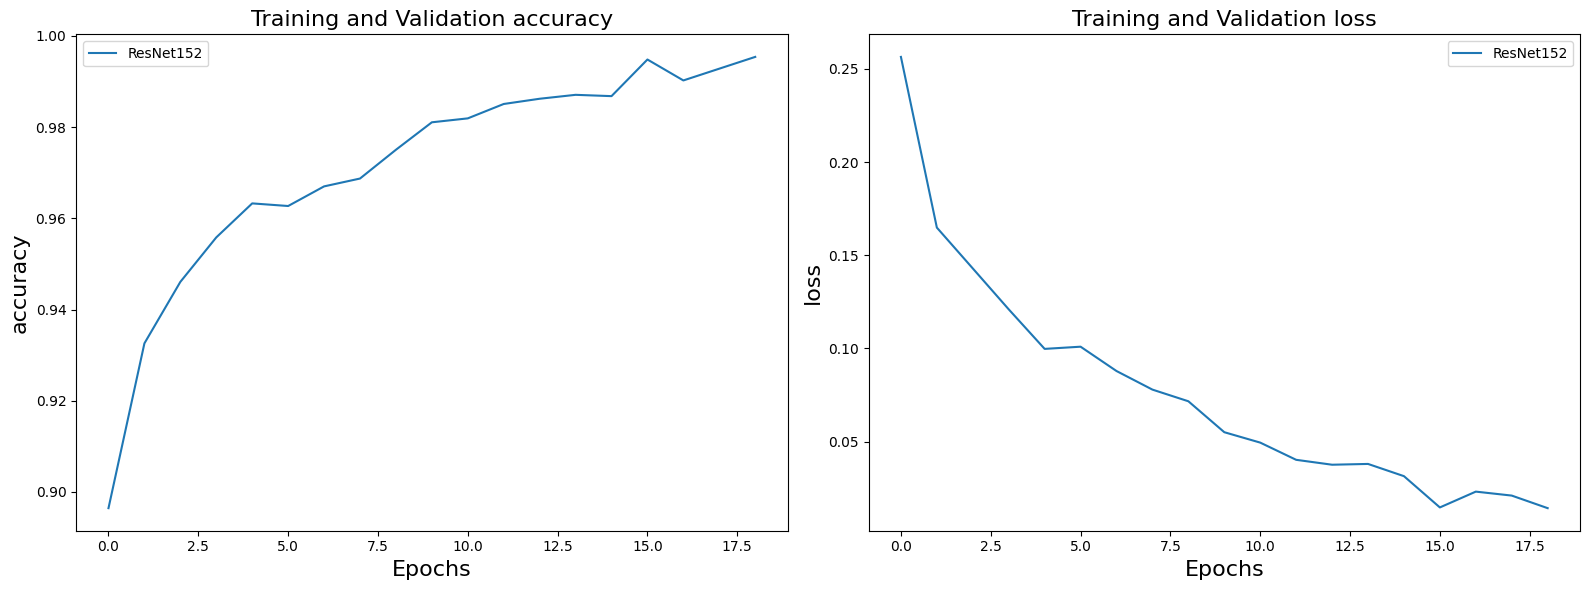

Finished in 0.657102 seconds


In [122]:
start_time = time.time()

metrics_to_plot = ['accuracy', 'loss']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(16, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i+1)  
    for idx, history in enumerate(model_histories):
        plt.plot(history[metric], label=Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}', fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

# Test the model

In [120]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

print(f"test_df size   : {ts_length}")
print(f"Test Batch Size: {test_batch_size}")
print(f"Test Steps     : {test_steps}")

start_time = time.time()

test_score  = model.evaluate(test_gen, steps= test_steps, verbose= 0)

inference_time = time.time() - start_time
print('-' * 20)
print("\nInference Time: {:.6f} seconds".format(inference_time))

print('-' * 20)
print(f"Test Loss: {test_score [0]}")
print(f"Test Accuracy: {test_score [1]}")

test_df size   : 499
Test Batch Size: 1
Test Steps     : 499
--------------------

Inference Time: 18.247265 seconds
--------------------
Test Loss: 0.11252739280462265
Test Accuracy: 0.9579158425331116


## Classification metrics: Confussion Matrix, ROC Curve, Precision-Recall Curve

499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step


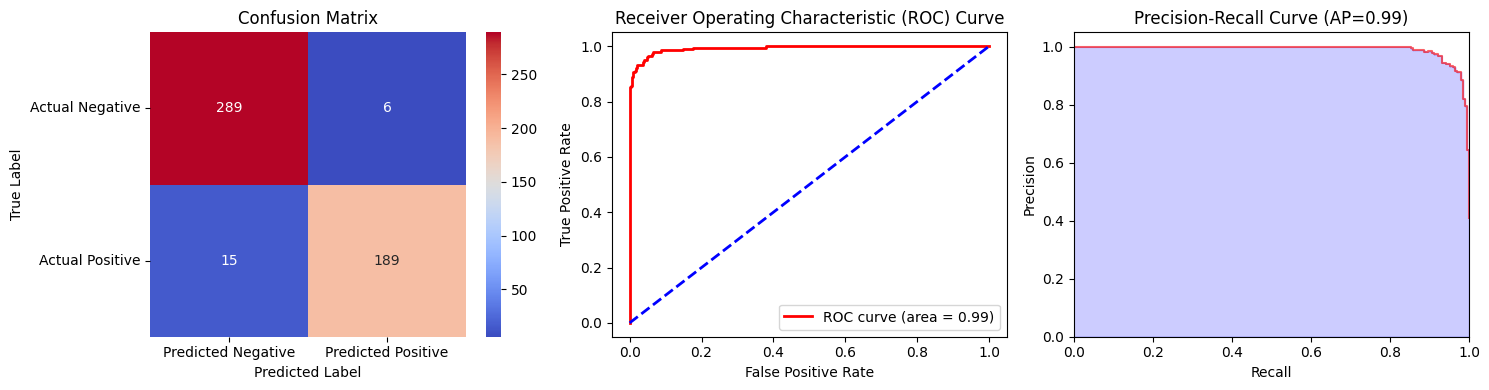

Finished in 9.870236 seconds


In [123]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

# Confusion Matrix
true_labels = test_gen.classes
predictions = model.predict(test_gen)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

plt.figure(figsize=(15, 4))

# Plot Confusion Matrix
plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)

# Plot ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)
plt.step(recall, precision, color='r', alpha=0.6, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))

plt.tight_layout()
plt.show()

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Classification metrics scores

In [124]:
start_time = time.time()

tn, fp, fn, tp = conf_matrix.ravel()
accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 2)
precision = round(tp / (tp + fp) * 100, 2) if (tp + fp) != 0 else 0
recall = round(tp / (tp + fn) * 100, 2) if (tp + fn) != 0 else 0
f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) != 0 else 0

print(f"\nTrue Positive  = {tp}")
print(f"False Positive = {fp}")
print(f"True Negative  = {tn}")
print(f"False Negative = {fn}")
print('\nAccuracy  = {:.4f}'.format(accuracy))
print('Precision = {:.4f}'.format(precision))
print('Recall    = {:.4f}'.format(recall))
print('F1 Score  = {:.4f}'.format(f1_score))

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


True Positive  = 189
False Positive = 6
True Negative  = 289
False Negative = 15

Accuracy  = 95.7900
Precision = 96.9200
Recall    = 92.6500
F1 Score  = 94.7400
Finished in 0.001296 seconds


## Prediction using faces from internet  

In [127]:
INET_IMG_DIR = os.path.join(os.getcwd(), 'internet_img/')

try:
    shutil.rmtree(INET_IMG_DIR)
    print(f"Directory '{INET_IMG_DIR}' deleted successfully.")
except FileNotFoundError:
    pass

os.makedirs(INET_IMG_DIR, exist_ok=True)

In [128]:
import requests
import re

def download_image_with_number(url, save_path, gender):
  basename = os.path.splitext(os.path.basename(save_path))[0]

  highest_number = 0
  for filename in os.listdir(save_path):
    match = re.search(rf"{gender}_(\d+)", filename)
    if match:
      highest_number = max(highest_number, int(match.group(1)))

  new_number = str(highest_number + 1).zfill(3)  
  filename = f"{save_path}{gender}_{new_number}.jpg"  

  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as f:
      for chunk in response.iter_content(1024):
        f.write(chunk)

    print(f"Image downloaded successfully from {url} and saved to {filename}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [129]:
image_url = "https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%20Bu%20Puan%20Maharani,%20Putri%20Bu%20Megawati%20Soekarnoputri%20dan%20Cucu%20Bung%20Karno%20Sang%20Proklamator.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://thumbs.dreamstime.com/b/handsome-latino-man-20185194.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/736x/ac/68/7c/ac687c962a1c40f23360c45b20c4d31a--beauty-queens-universe.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://i.pinimg.com/originals/9f/a3/e4/9fa3e48c7f9696ee4bf337af74136a28.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.ursulasweeklywanders.com/wp-content/uploads/2020/02/08-22825-post/000003-Enga-Woman_1803.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://allthatsinteresting.com/wordpress/wp-content/uploads/2014/05/old-eskimo.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://live.staticflickr.com/4105/4951753576_91e36b48cc_o.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://images.saymedia-content.com/.image/t_share/MTc0NDg2ODMwMjY2MTk3MzUy/top-10-kpop-male-solo-artists.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/originals/90/39/a7/9039a708273088667c4562cab89c39e6.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://1.bp.blogspot.com/-rUOpHKW7HiU/Xyu01mP955I/AAAAAAAA_CM/HDly5twbSpcu_YiabKguiz4QZqT5UEnnQCLcBGAsYHQ/s500/75a655086de9e657eeb1699ed4fccbf2.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

Image downloaded successfully from https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg and saved to /kaggle/working/internet_img/male_001.jpg
Image downloaded successfully from https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg and saved to /kaggle/working/internet_img/male_002.jpg
Image downloaded successfully from https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg and saved to /kaggle/working/internet_img/female_001.jpg
Image downloaded successfully from https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%2

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction [[0.48187682]]


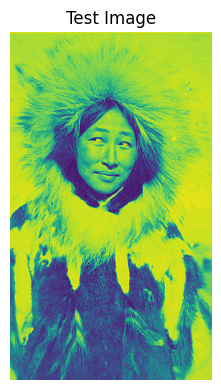

Image: /kaggle/working/internet_img/female_004.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction [[0.43646094]]


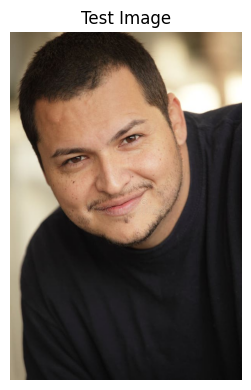

Image: /kaggle/working/internet_img/male_003.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction [[0.4336305]]


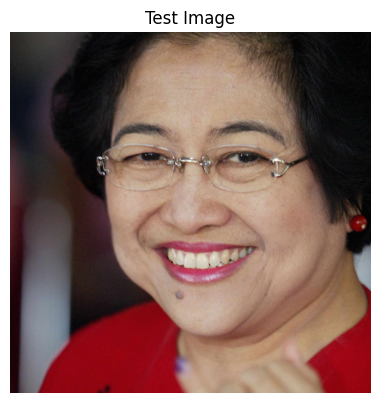

Image: /kaggle/working/internet_img/female_001.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction [[0.45269385]]


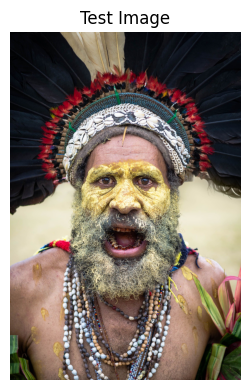

Image: /kaggle/working/internet_img/male_004.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction [[0.4723973]]


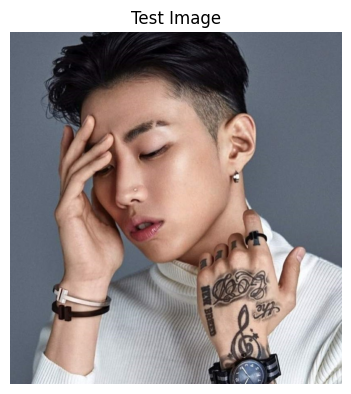

Image: /kaggle/working/internet_img/male_006.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction [[0.44102177]]


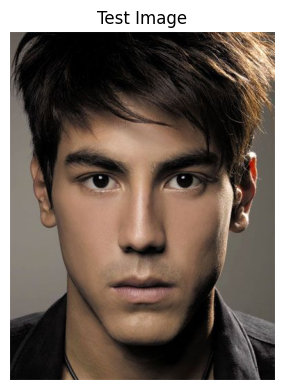

Image: /kaggle/working/internet_img/male_007.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction [[0.43046987]]


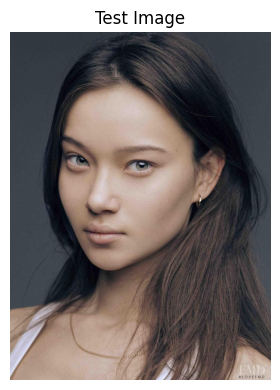

Image: /kaggle/working/internet_img/female_005.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction [[0.41080332]]


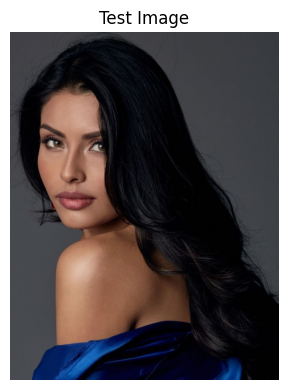

Image: /kaggle/working/internet_img/female_003.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction [[0.45771635]]


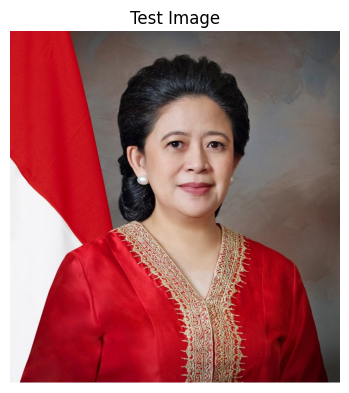

Image: /kaggle/working/internet_img/female_002.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction [[0.45669052]]


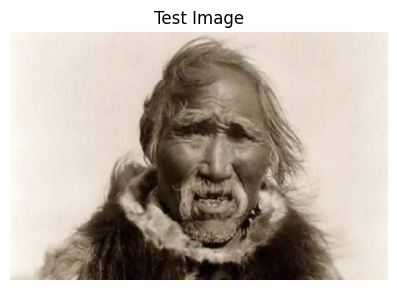

Image: /kaggle/working/internet_img/male_005.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction [[0.43910906]]


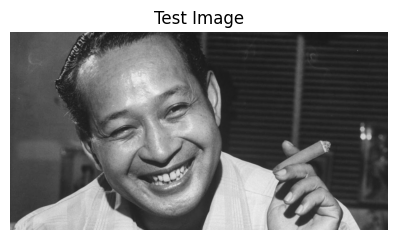

Image: /kaggle/working/internet_img/male_002.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction [[0.44840494]]


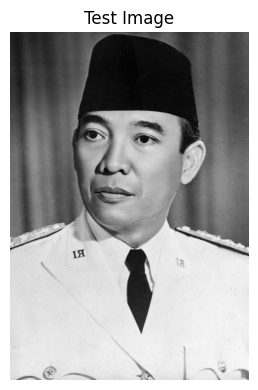

Image: /kaggle/working/internet_img/male_001.jpg
Model predicts: Male
------------------------------


In [130]:
from glob import glob
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input

image_paths = glob(f"{INET_IMG_DIR}*.jpg")  

for image_path in image_paths:
  img = image.load_img(image_path, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  prediction = model.predict(img_array)

  print(f"Prediction {prediction}")

  female_prob = round(1 - prediction[0][0] * 100, 2)
  male_prob = round(prediction[0][0] * 100, 2)

  if male_prob > female_prob:
    result = "Male"
  else:
    result = "Female"

  plt.figure(figsize=(8, 4))

  plt.subplot(1, 2, 1)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Test Image')

  plt.tight_layout()
  plt.show()

  print(f"Image: {image_path}")
  print(f"Model predicts: {result}")
  print("-" * 30)

In [ ]:
WEIGHTS_DIR = os.path.join(os.getcwd(), 'weights')

try:
    shutil.rmtree(WEIGHTS_DIR)
    print(f"Directory '{WEIGHTS_DIR}' deleted successfully.")
except FileNotFoundError:
    pass

os.makedirs(WEIGHTS_DIR, exist_ok=True)

In [ ]:
model.save("weights/Resnet152-RyanSA.h5")